# Selección de variables y regularización

## DAVID MONTERO LOAIZA

_Santander Meteorology Group (09-01-2020)_

 * [Introducción](#Introducción)
 * [Base de datos de ejemplo: Breast cancer](#Base-de-datos:-Breast-cancer)
 * [Modelo lineal completo](#Modelo-lineal-completo)
 * [Selección de variables](#Selección-de-variables)
 * [Regularización](#Regularización)

## Introducción
El objetivo principal de un modelo entrenado es que tenga la capacidad de generalizar, es decir, la capacidad de predecir bien nuevos datos que no formen parte de la muestra de entrenamiento (por ejemplo, una muestra de datos de *test*). La relación entre el número de observaciones y el número de variables independientes es clave en la capacidad de generalización de los modelos.

Para evitar el sobreajuste en situaciones donde el número de observaciones es del orden, o menor, que el de grados de libertad del sistema y/o donde hay colinealidad, se utilizan (entre otras) técnicas como la selección de variables y la regularización. La primera permite seleccionar de forma objetiva un subconjunto de variables predictoras, mientras que la segunda actúa sobre los parámetros del modelo, impidiendo que tomen valores elevados que harían al modelo muy sensible a diferentes muestras de entrenamiento.

## Base de datos: Breast cancer

En este ejemplo trabajaremos con la base de datos [_Breast cancer_ (Diagnostic)](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), incluida en Kaggle. El objetivo de este conjunto de datos es clasificar a las pacientes en base a si el cáncer de mama que tienen es benigno (`B`) o maligno (`M`). Para ello se utilizan 31 predictores relacionados con las propiedades de las células cancerígenas, que en comparación con el número de observaciones (569) es bajo.

Preparamos la base de datos de la siguiente manera:

In [0]:
bcURL = "https://raw.githubusercontent.com/davemlz/Master_of_DataScience/master/Estadistica/Seleccion%20de%20variables%20y%20regularizacion%2010/breastcancer.csv"

In [70]:
# data <- read.csv("../datasets/breastcancer.csv")
data = read.csv(url(bcURL))
# Eliminar no predictores (id y última columna vacía)
df <- data[, -c(1, ncol(data)-1, ncol(data))]
# Convertir el factor diagnosis (B y M) a los valores numéricos 0 y 1, respectivamente.
levels(df$diagnosis) <- c(0,1) 
df$diagnosis <- as.numeric(as.character(df$diagnosis))
# Normalizar los datos para evitar problemas de diferente variabilidad
df[-1] <- apply(df[-1], MARGIN = 2, scale)
rm(data)
dim(df)
names(df)

[1] 569  30

[1] "diagnosis"              "radius_mean"            "texture_mean"          
 [4] "perimeter_mean"         "area_mean"              "smoothness_mean"       
 [7] "compactness_mean"       "concavity_mean"         "concave.points_mean"   
[10] "symmetry_mean"          "fractal_dimension_mean" "radius_se"             
[13] "texture_se"             "perimeter_se"           "area_se"               
[16] "smoothness_se"          "compactness_se"         "concavity_se"          
[19] "concave.points_se"      "symmetry_se"            "fractal_dimension_se"  
[22] "radius_worst"           "texture_worst"          "perimeter_worst"       
[25] "area_worst"             "smoothness_worst"       "compactness_worst"     
[28] "concavity_worst"        "concave.points_worst"   "symmetry_worst"

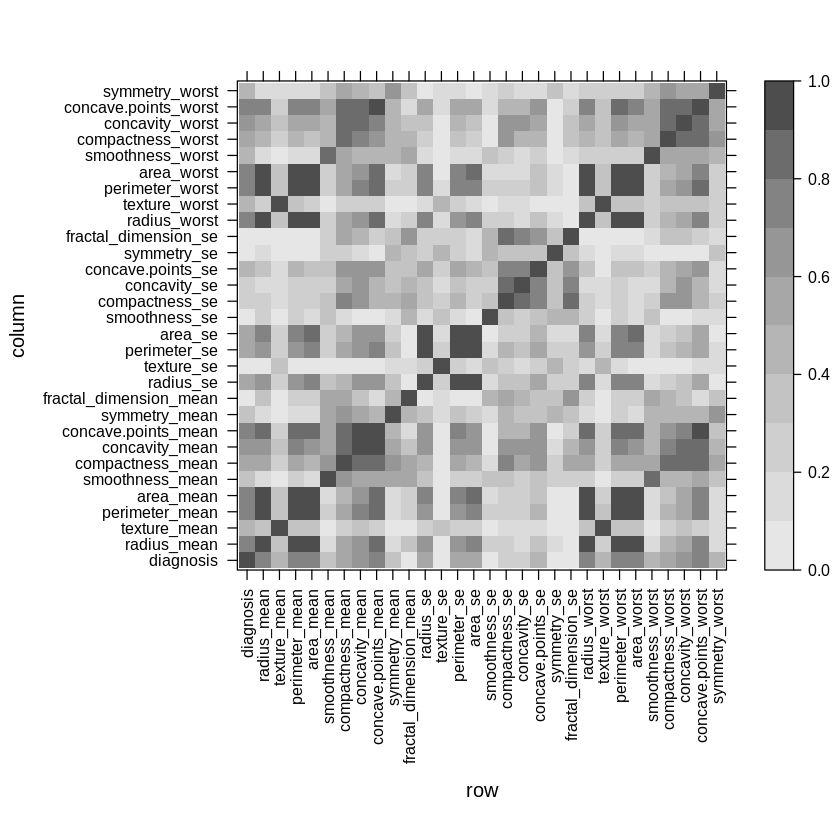

In [3]:
library(lattice) # levelplot
cor.matrix <- abs(cor(df))
levelplot(cor.matrix, at = seq(0, 1, 0.1), col.regions = rev(grey.colors(10)),
          scale = list(x = list(rot = 90)))

## Modelo lineal completo

In [5]:
install.packages("verification")
install.packages("caret")
install.packages("e1071")
library(verification, quietly = TRUE) # roc.area
library(caret, quietly = TRUE) # confusionMatrix

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dotCall64’, ‘spam’, ‘maps’, ‘proxy’, ‘fields’, ‘CircStats’, ‘dtw’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘recipes’, ‘pROC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

Ahora construimos el modelo lineal mediante la función glm. Como la variable respuesta sigue una distribución de Bernouilli lo más apropiado es realizar una regresión logística.

In [6]:
model <- glm(diagnosis ~ ., data = df, family = "binomial")
pred  <- predict(model,df[-1], type = "response")

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Para comprobar la validez de nuestro modelo en la clasificación del cáncer de mama, utilizaremos el índice Área bajo la curva ROC (AUC, por sus siglas en inglés) disponible en la librería `verification` (cargada previamente).

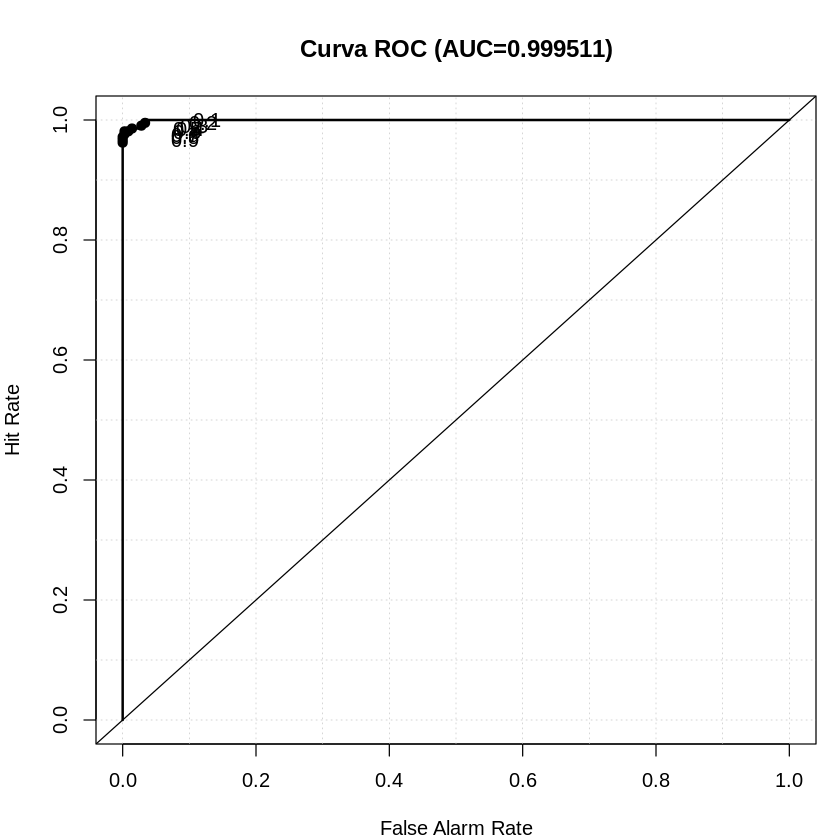

In [7]:
roc.plot(df$diagnosis,pred,
  main=sprintf("Curva ROC (AUC=%g)", roc.area(obs = df$diagnosis,pred)$A)
)

**TAREA 1:** Estudiar la capacidad de generalización del modelo completo mediante una validacion cruzada de tipo *hold out*, es decir, utilizando una parte de los datos para entrenar el modelo y reservando otra para probarlo.

In [0]:
trainIdx = createDataPartition(df$diagnosis, p = .6, list = FALSE)
 
trainData = df[trainIdx,]
testData = df[-trainIdx,]

In [108]:
trainModel = glm(diagnosis ~ ., data = trainData, family = "binomial")

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [0]:
trainPred = predict(trainModel,trainData, type = "response")
testPred = predict(trainModel,testData, type = "response")

In [110]:
confusionMatrix(as.factor(round(trainPred)),as.factor(trainData$diagnosis))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 208   0
         1   0 134
                                     
               Accuracy : 1          
                 95% CI : (0.9893, 1)
    No Information Rate : 0.6082     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.6082     
         Detection Rate : 0.6082     
   Detection Prevalence : 0.6082     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [111]:
confusionMatrix(as.factor(round(testPred)),as.factor(testData$diagnosis))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 145   5
         1   4  73
                                          
               Accuracy : 0.9604          
                 95% CI : (0.9261, 0.9817)
    No Information Rate : 0.6564          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9118          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9732          
            Specificity : 0.9359          
         Pos Pred Value : 0.9667          
         Neg Pred Value : 0.9481          
             Prevalence : 0.6564          
         Detection Rate : 0.6388          
   Detection Prevalence : 0.6608          
      Balanced Accuracy : 0.9545          
                                          
       'Positive' Class : 0               
                              

En este caso, el accuracy de el dataset de train es 1, claramente muestra un sobreajuste, aunque el accuracy del dataset de test sea alto.

## Selección de variables



### Selección del mejor subconjunto

La función `regsubsets` (`?regsubsets`) de la librería `leaps` nos permite realizar la selección del mejor subconjunto con un número dado de predictores. La sintaxis es similar a la usada para el modelo lineal (`lm`) y, del mismo modo, el comando `summary` nos permite explorar los resultados. Utilizamos el argumento `nvmax` para forzar la utilización de todas las variables (30), ya que por defecto la función regsubsets solo utiliza las 8 primeras.

In [33]:
install.packages('leaps')
library(leaps)
regfit.full <- regsubsets(diagnosis ~., df, nvmax = 30)
full.summary <- summary(regfit.full)
names(full.summary)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

La función `summary` devuelve medidas del ajuste que se pueden usar para seleccionar el mejor modelo. En particular, si revisamos los valores del ajuste, en este caso rsq, se observa que el estadístico va mejorando a medida que aumentamos el número de variables en el modelo. Sin embargo, si nos fijamos en el estadístico BIC (*Bayesian information criterion*), que penaliza la complejidad del modelo, se observa que los valores óptimos se encuentran considerando 11 variables.

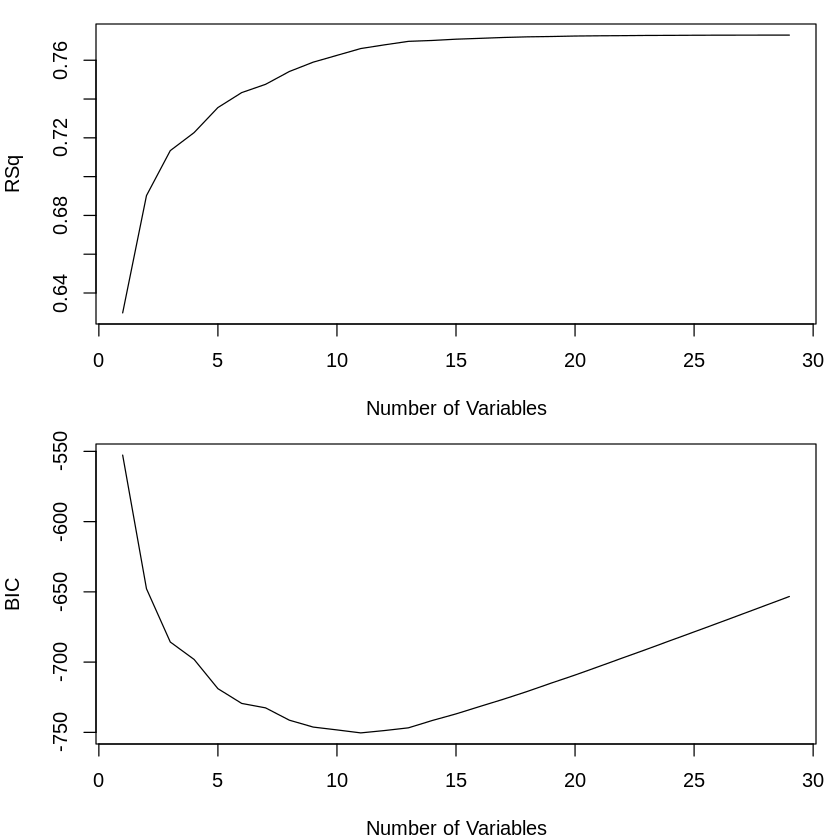

In [34]:
par(mfrow=c(2,1), mar=c(4,4,1,1))
plot(full.summary$rsq,xlab="Number of Variables",ylab="RSq", type="l")
plot(full.summary$bic,xlab="Number of Variables",ylab="BIC", type="l")

In [35]:
which.min(full.summary$bic)

[1] 11

La propia función `regsubsets` incorpora un método para dibujar los resultados clasificados según los diferentes estadísticos (`? plot.regsubsets`)

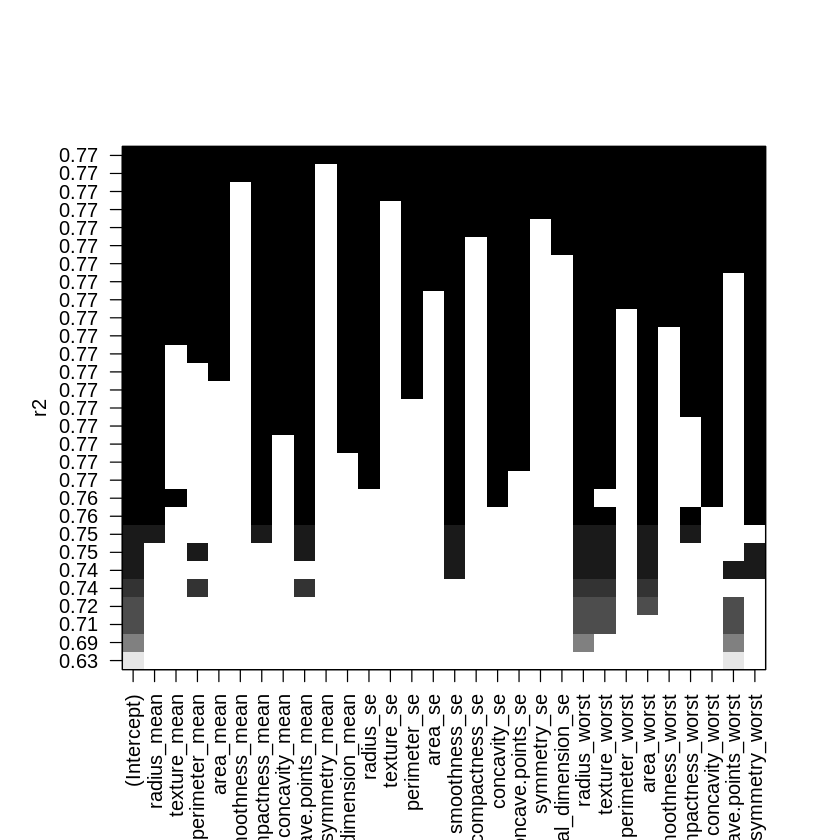

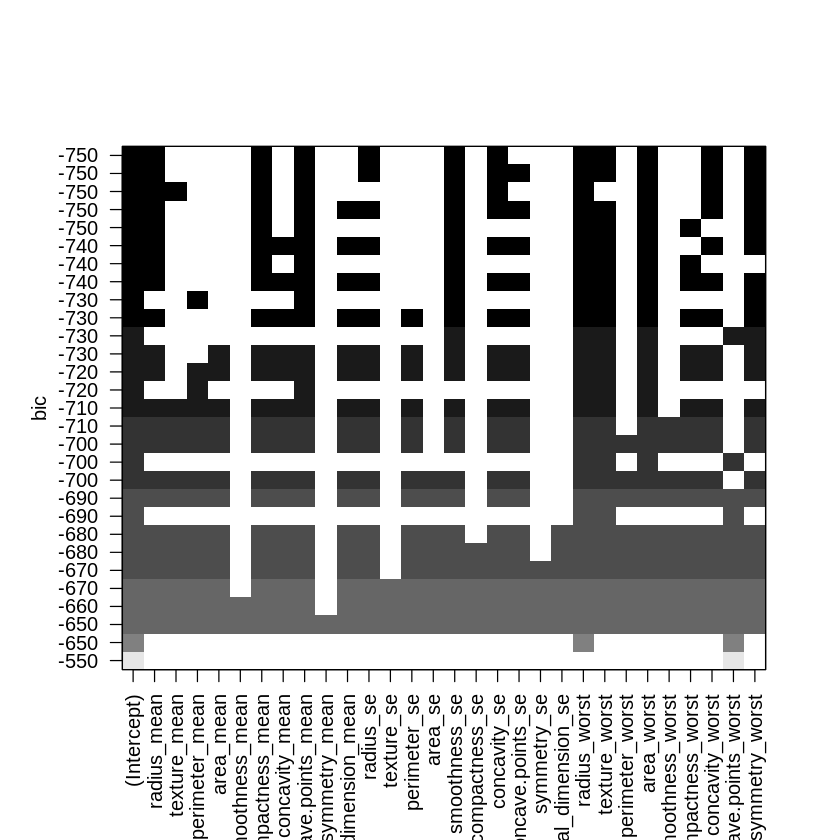

In [36]:
plot(regfit.full, scale ="r2")
plot(regfit.full, scale ="bic")

Cada fila de este gráfico representa el mejor modelo ajustado para un número dado de variables. Cada cuadrado de color representa que la variable entra en ese modelo, mientras que la intensidad del color se asocia con la escala del eje Y. Si, una vez localizado el modelo óptimo (en nuestro caso, el de 11 variables), queremos conocer los coeficientes del modelo, podemos usar la función `coef` con un segundo argumento:

In [37]:
coef(regfit.full, 11)

(Intercept)         radius_mean    compactness_mean concave.points_mean 
         1.37258348         -0.17840169         -0.12933228          0.19664469 
          radius_se       smoothness_se        concavity_se        radius_worst 
         0.05803878          0.06566972         -0.06679611          0.87351926 
      texture_worst          area_worst     concavity_worst      symmetry_worst 
         0.06189087         -0.56390219          0.15446712          0.04610665

### Selección stepwise
Con un leve cambio en los argumentos de la función podemos realizar la selección stepwise, ya sea “forward” o “backward”:

In [0]:
regfit.fwd <- regsubsets(diagnosis~., data = df, nvmax = 30 , method ="forward")
fwd.summary <- summary(regfit.fwd)

**TAREA 2:** Estudiar los predictores seleccionados en este caso. ¿cuál es su múmero óptimo? ¿coinciden con los anteriores?

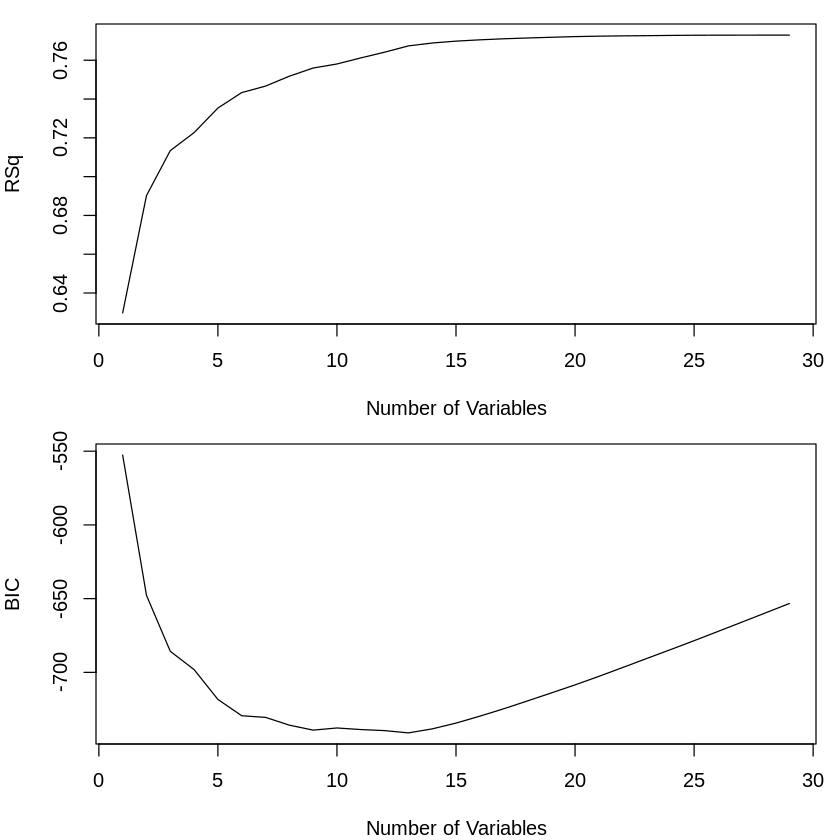

In [39]:
par(mfrow=c(2,1), mar=c(4,4,1,1))
plot(fwd.summary$rsq,xlab="Number of Variables",ylab="RSq", type="l")
plot(fwd.summary$bic,xlab="Number of Variables",ylab="BIC", type="l")

In [43]:
min.fwd = which.min(fwd.summary$bic)
min.fwd

[1] 13

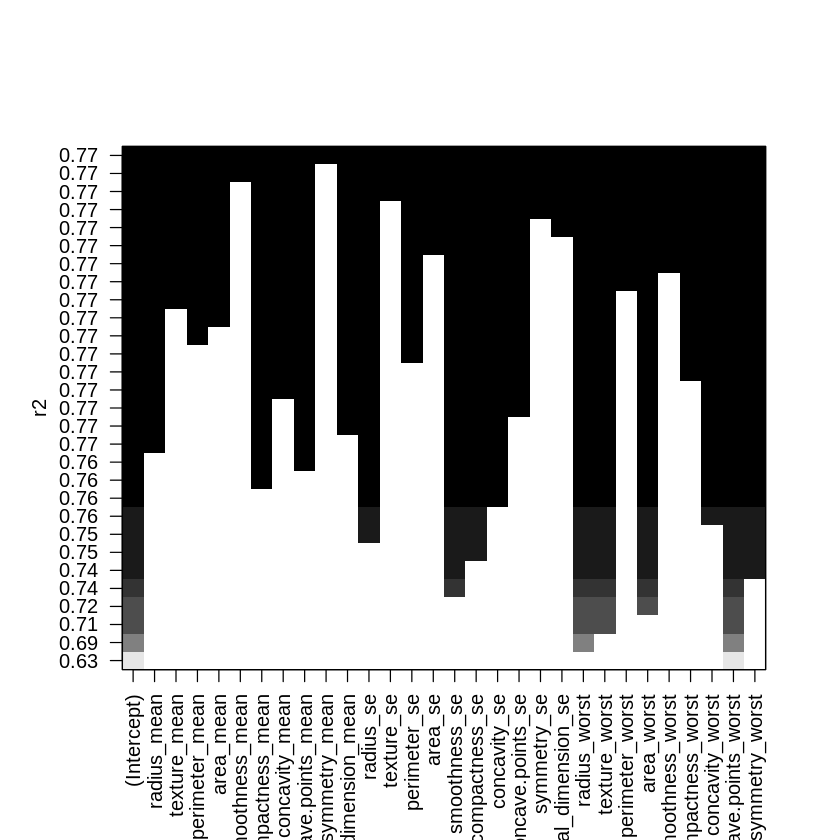

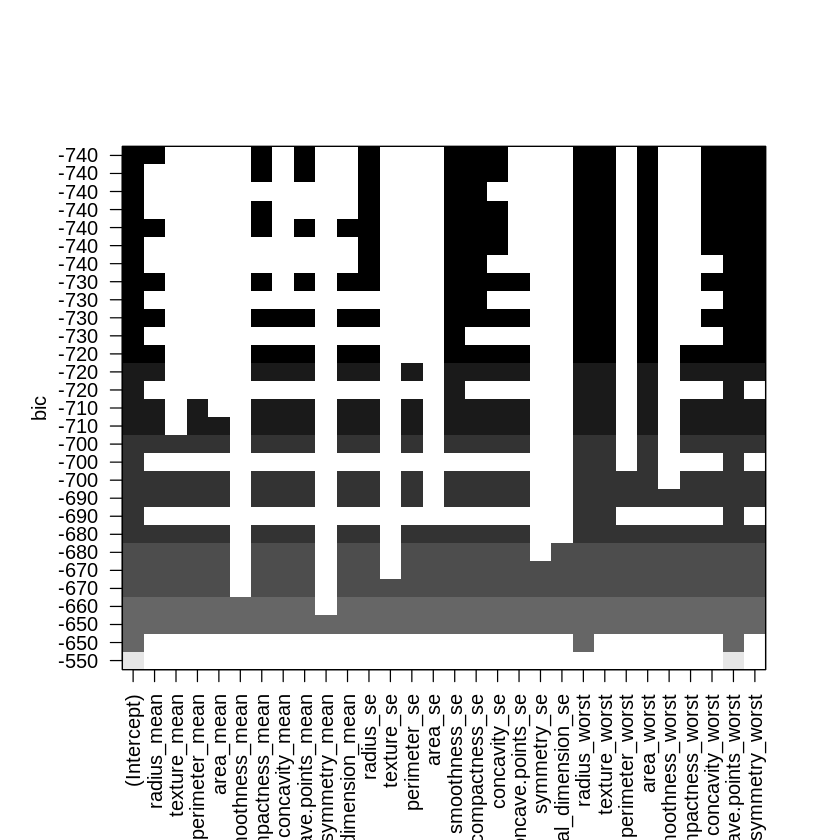

In [41]:
plot(regfit.fwd, scale ="r2")
plot(regfit.fwd, scale ="bic")

In [44]:
coef(regfit.fwd,min.fwd)

(Intercept)          radius_mean     compactness_mean 
         1.372583480         -0.152417810         -0.135425313 
 concave.points_mean            radius_se        smoothness_se 
         0.160385466          0.065775054          0.065217637 
      compactness_se         concavity_se         radius_worst 
         0.007250479         -0.068634623          0.805709990 
       texture_worst           area_worst      concavity_worst 
         0.062312893         -0.534048738          0.133570605 
concave.points_worst       symmetry_worst 
         0.066225174          0.044167695

In [50]:
coef.fwd = names(coef(regfit.fwd,min.fwd))
coef.full = names(coef(regfit.full,11))

coef.fwd[!(coef.fwd %in% coef.full)]

[1] "compactness_se"       "concave.points_worst"

En el caso de realizarlo Exhaustivo, se han obtenido 11 variables como las óptimas, mientras que al realizarlo en método Forward, se han obtenido un total de 13 variables como las óptimas (se agregan las variables `compactness_se` y `concave.points_worst`).

**TAREA 3:** Comparar la selección realizada por el método backward con los métodos exhaustivo y _forward stepwise_.

In [0]:
regfit.bwd <- regsubsets(diagnosis~., data = df, nvmax = 30 , method ="backward")
bwd.summary <- summary(regfit.bwd)

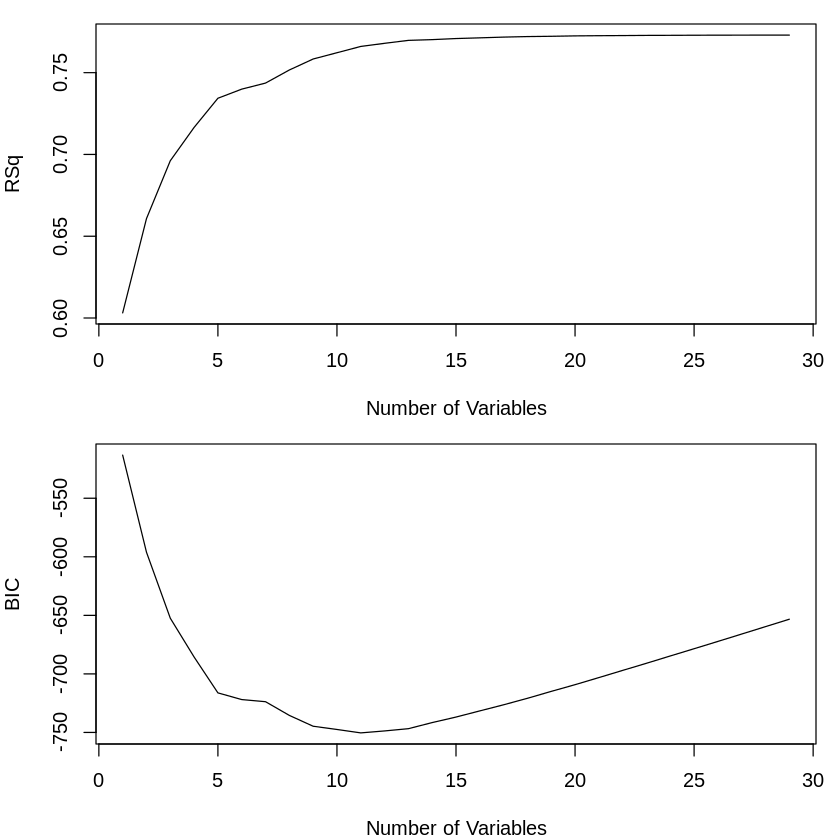

In [52]:
par(mfrow=c(2,1), mar=c(4,4,1,1))
plot(bwd.summary$rsq,xlab="Number of Variables",ylab="RSq", type="l")
plot(bwd.summary$bic,xlab="Number of Variables",ylab="BIC", type="l")

In [53]:
min.bwd = which.min(bwd.summary$bic)
min.bwd

[1] 11

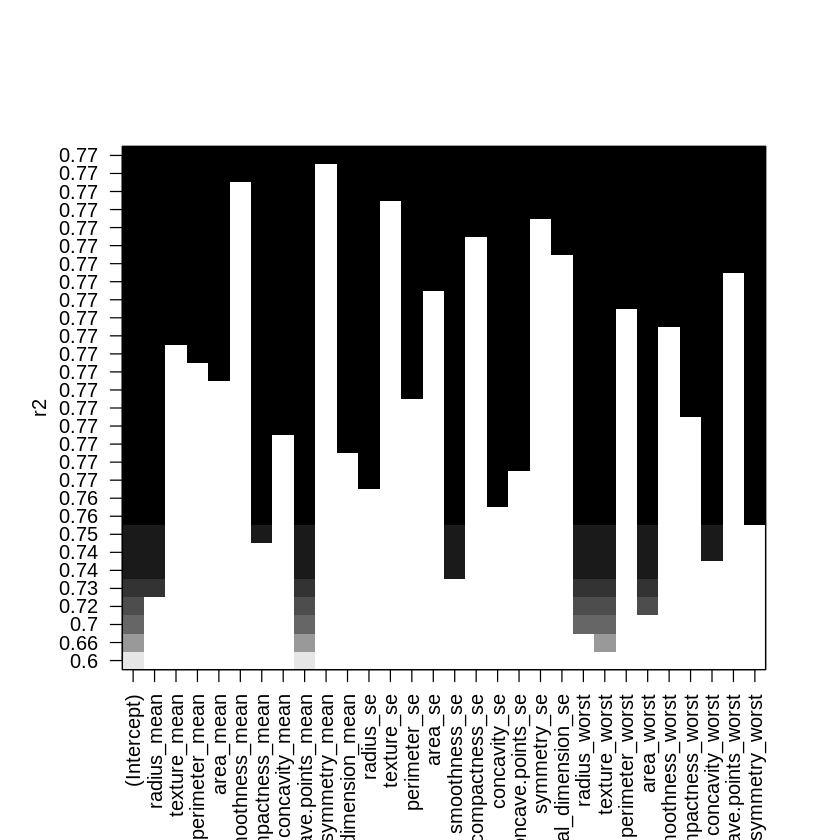

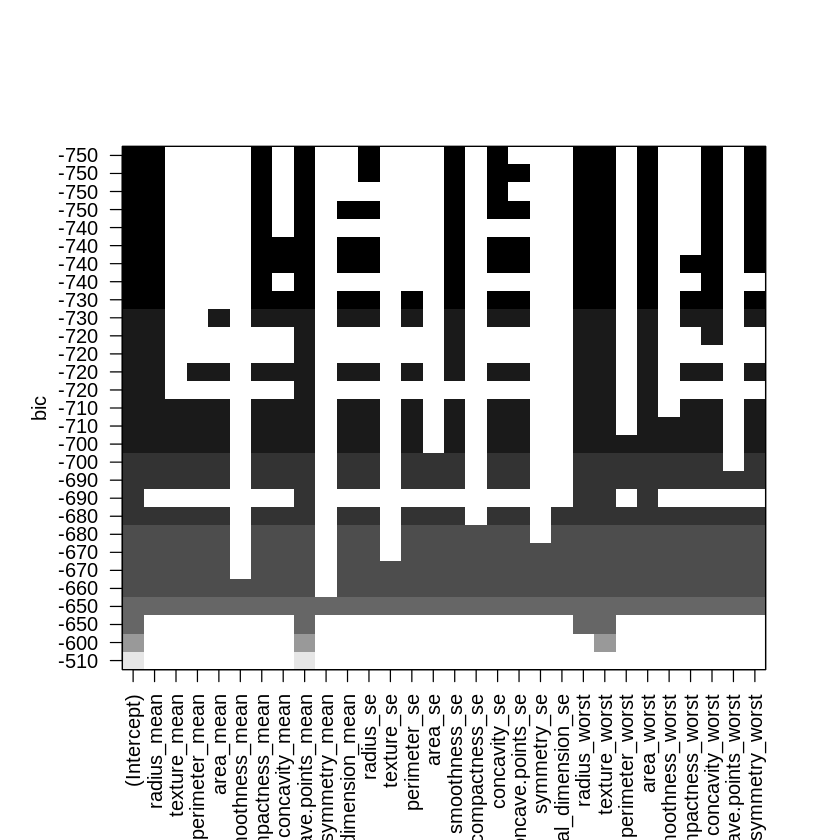

In [54]:
plot(regfit.bwd, scale ="r2")
plot(regfit.bwd, scale ="bic")

In [56]:
coef(regfit.bwd,min.bwd)

(Intercept)         radius_mean    compactness_mean concave.points_mean 
         1.37258348         -0.17840169         -0.12933228          0.19664469 
          radius_se       smoothness_se        concavity_se        radius_worst 
         0.05803878          0.06566972         -0.06679611          0.87351926 
      texture_worst          area_worst     concavity_worst      symmetry_worst 
         0.06189087         -0.56390219          0.15446712          0.04610665

In [63]:
coef.bwd = names(coef.bwd)

coef.bwd[!(coef.bwd %in% coef.full)]

NULL

Las variables seleccionadas en el método Backward son las mismas seleccionadas por el método exhausrivo. Siendo las variables `compactness_se` y `concave.points_worst`, seleccionadas por el método Forward, las únicas diferentes entre los tres métodos.

Otra opción para realizar la selección _stepwise_ es usar la función `step`, que forma parte del paquete básico `stats` de R:

In [64]:
initialModel_0 <- glm(diagnosis ~ 1, data = df, family=binomial(link="logit"))
initialModel_p <- glm(diagnosis ~ ., data = df, family=binomial(link="logit"))

fw <- step(initialModel_0,
  scope = list(lower = formula(initialModel_0), upper = formula(initialModel_p)),
  direction = "forward"
)
summary(fw)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Start:  AIC=753.44
diagnosis ~ 1



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                         Df Deviance    AIC
+ perimeter_worst         1   209.48 213.48
+ radius_worst            1   229.11 233.11
+ area_worst              1   230.64 234.64
+ concave.points_worst    1   250.45 254.45
+ concave.points_mean     1   258.92 262.92
+ perimeter_mean          1   304.48 308.48
+ area_mean               1   325.66 329.66
+ radius_mean             1   330.01 334.01
+ area_se                 1   359.50 363.50
+ concavity_mean          1   383.23 387.23
+ concavity_worst         1   437.70 441.70
+ perimeter_se            1   472.83 476.83
+ radius_se               1   480.65 484.65
+ compactness_worst       1   505.55 509.55
+ compactness_mean        1   508.79 512.79
+ texture_worst           1   622.07 626.07
+ symmetry_worst          1   641.42 645.42
+ smoothness_worst        1   641.42 645.42
+ concave.points_se       1   646.01 650.01
+ texture_mean            1   646.52 650.52
+ smoothness_mean         1   673.95 677.95
+ symmetry_mean           1   68

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                         Df Deviance    AIC
+ smoothness_worst        1   139.18 145.18
+ concave.points_worst    1   149.59 155.59
+ texture_worst           1   159.68 165.68
+ concave.points_mean     1   162.47 168.47
+ smoothness_mean         1   165.18 171.18
+ symmetry_worst          1   167.85 173.85
+ concavity_worst         1   168.55 174.55
+ concavity_mean          1   169.78 175.78
+ radius_mean             1   173.15 179.15
+ compactness_worst       1   175.42 181.42
+ symmetry_mean           1   177.18 183.18
+ fractal_dimension_mean  1   177.62 183.62
+ texture_mean            1   178.63 184.63
+ area_mean               1   180.70 186.70
+ compactness_mean        1   181.84 187.84
+ perimeter_mean          1   183.59 189.59
+ smoothness_se           1   191.06 197.06
+ texture_se              1   195.30 201.30
+ concave.points_se       1   198.67 204.67
+ radius_se               1   199.25 205.25
+ area_se                 1   201.45 207.45
+ symmetry_se             1   20

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                         Df Deviance    AIC
+ texture_worst           1   103.61 111.61
+ texture_mean            1   106.84 114.84
+ texture_se              1   122.51 130.51
+ area_se                 1   123.42 131.42
+ radius_se               1   124.89 132.90
+ perimeter_se            1   130.42 138.42
+ concavity_mean          1   133.31 141.31
+ symmetry_worst          1   134.45 142.45
+ area_worst              1   134.65 142.65
+ symmetry_se             1   135.31 143.31
+ concave.points_mean     1   135.35 143.35
+ concave.points_worst    1   135.57 143.57
+ concavity_worst         1   135.97 143.97
+ symmetry_mean           1   136.21 144.21
+ concave.points_se       1   136.32 144.32
<none>                        139.18 145.18
+ concavity_se            1   137.42 145.42
+ radius_worst            1   137.53 145.53
+ radius_mean             1   137.66 145.66
+ perimeter_mean          1   137.81 145.81
+ smoothness_se           1   138.54 146.54
+ area_mean               1   13

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=111.61
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance     AIC
+ radius_se               1   87.205  97.205
+ area_se                 1   87.437  97.437
+ perimeter_se            1   94.237 104.237
+ concave.points_mean     1   94.884 104.884
+ concave.points_se       1   98.633 108.633
+ symmetry_mean           1   98.669 108.669
+ concavity_mean          1   98.727 108.727
+ symmetry_se             1   98.826 108.826
+ concave.points_worst    1   99.349 109.349
+ symmetry_worst          1  100.170 110.170
+ area_worst              1  100.526 110.526
+ radius_worst            1  101.505 111.505
<none>                       103.612 111.612
+ smoothness_mean         1  101.830 111.830
+ concavity_worst         1  102.514 112.514
+ concavity_se            1  102.560 112.560
+ texture_mean            1  103.218 113.218
+ fractal_dimension_se    1  103.224 113.224
+ texture_se              1  103.237 113.237
+ smoothness_se           1  103.285 113.285
+ compactness_worst       1  103.360 113.360
+ compactn

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=97.2
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ symmetry_worst          1   79.073 91.073
+ concave.points_worst    1   79.196 91.196
+ texture_se              1   82.558 94.558
+ concave.points_mean     1   84.004 96.004
+ concavity_worst         1   84.146 96.146
+ fractal_dimension_se    1   84.287 96.287
+ symmetry_mean           1   84.542 96.542
+ compactness_se          1   84.888 96.888
+ perimeter_se            1   85.151 97.151
+ concavity_mean          1   85.159 97.159
<none>                        87.205 97.205
+ area_worst              1   85.805 97.805
+ smoothness_se           1   85.810 97.810
+ symmetry_se             1   86.025 98.025
+ radius_worst            1   86.030 98.030
+ compactness_mean        1   86.597 98.597
+ fractal_dimension_mean  1   86.729 98.729
+ perimeter_mean          1   86.780 98.780
+ radius_mean             1   86.873 98.873
+ area_mean               1   87.043 99.043
+ texture_mean            1   87.050 99.050
+ smoothness_mean         1   87

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=91.07
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ compactness_se          1   74.511 88.511
+ concave.points_worst    1   74.850 88.850
+ fractal_dimension_se    1   75.551 89.551
+ texture_se              1   75.869 89.869
+ area_worst              1   76.196 90.196
+ compactness_mean        1   76.436 90.436
+ perimeter_se            1   76.737 90.737
+ radius_worst            1   76.821 90.821
+ fractal_dimension_mean  1   76.900 90.900
+ concave.points_mean     1   76.974 90.974
<none>                        79.073 91.073
+ compactness_worst       1   77.638 91.638
+ concavity_worst         1   78.142 92.142
+ symmetry_se             1   78.211 92.211
+ concavity_mean          1   78.438 92.438
+ area_se                 1   78.494 92.494
+ smoothness_mean         1   78.730 92.730
+ smoothness_se           1   78.772 92.772
+ symmetry_mean           1   78.803 92.803
+ area_mean               1   78.899 92.899
+ concavity_se            1   78.973 92.973
+ radius_mean             1   78

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=88.51
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ concavity_mean          1   65.529 81.529
+ concave.points_worst    1   65.593 81.593
+ concave.points_mean     1   67.066 83.066
+ concavity_worst         1   67.234 83.234
+ concave.points_se       1   68.551 84.551
+ concavity_se            1   69.777 85.777
<none>                        74.511 88.511
+ texture_se              1   72.725 88.725
+ perimeter_se            1   73.232 89.232
+ smoothness_se           1   73.614 89.614
+ area_se                 1   73.733 89.733
+ area_worst              1   74.085 90.085
+ radius_worst            1   74.330 90.330
+ symmetry_se             1   74.406 90.406
+ fractal_dimension_mean  1   74.408 90.408
+ texture_mean            1   74.443 90.443
+ compactness_mean        1   74.471 90.471
+ smoothness_mean         1   74.491 90.491
+ perimeter_mean          1   74.498 90.498
+ compactness_worst       1   74.501 90.501
+ fractal_dimension_se    1   74.502 90.502
+ radius_mean             1   74

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=81.53
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ texture_se              1   61.258 79.258
+ concave.points_worst    1   61.850 79.850
+ area_se                 1   63.217 81.217
<none>                        65.529 81.529
+ perimeter_se            1   63.661 81.661
+ area_worst              1   63.951 81.951
+ concave.points_se       1   63.965 81.965
+ radius_worst            1   64.003 82.003
+ compactness_mean        1   64.078 82.078
+ concavity_worst         1   64.328 82.328
+ concave.points_mean     1   64.438 82.438
+ fractal_dimension_mean  1   64.621 82.621
+ smoothness_se           1   64.905 82.905
+ symmetry_mean           1   64.943 82.943
+ fractal_dimension_se    1   65.196 83.196
+ texture_mean            1   65.351 83.351
+ smoothness_mean         1   65.353 83.353
+ symmetry_se             1   65.399 83.399
+ area_mean               1   65.487 83.487
+ concavity_se            1   65.506 83.506
+ radius_mean             1   65.513 83.513
+ perimeter_mean          1   65

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=79.26
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ area_se                 1   58.643 78.643
+ concave.points_worst    1   58.739 78.739
+ area_worst              1   59.167 79.167
<none>                        61.258 79.258
+ radius_worst            1   59.387 79.387
+ perimeter_se            1   59.954 79.954
+ compactness_mean        1   60.049 80.049
+ concave.points_se       1   60.277 80.277
+ concave.points_mean     1   60.323 80.323
+ texture_mean            1   60.489 80.489
+ fractal_dimension_mean  1   60.498 80.498
+ fractal_dimension_se    1   60.500 80.500
+ concavity_worst         1   60.579 80.579
+ smoothness_se           1   60.674 80.674
+ area_mean               1   61.103 81.103
+ radius_mean             1   61.162 81.162
+ compactness_worst       1   61.166 81.166
+ smoothness_mean         1   61.214 81.214
+ symmetry_mean           1   61.254 81.254
+ perimeter_mean          1   61.254 81.254
+ concavity_se            1   61.255 81.255
+ symmetry_se             1   61

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=78.64
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se + area_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ concave.points_worst    1   54.713 76.713
<none>                        58.643 78.643
+ radius_worst            1   57.113 79.113
+ concave.points_se       1   57.485 79.485
+ concavity_worst         1   57.520 79.520
+ perimeter_se            1   57.525 79.525
+ texture_mean            1   57.593 79.593
+ concave.points_mean     1   57.669 79.669
+ area_worst              1   57.684 79.684
+ compactness_mean        1   58.146 80.146
+ symmetry_se             1   58.236 80.236
+ perimeter_mean          1   58.374 80.374
+ fractal_dimension_se    1   58.503 80.503
+ compactness_worst       1   58.538 80.538
+ fractal_dimension_mean  1   58.549 80.549
+ radius_mean             1   58.590 80.590
+ area_mean               1   58.590 80.590
+ smoothness_se           1   58.599 80.599
+ symmetry_mean           1   58.609 80.609
+ concavity_se            1   58.616 80.616
+ smoothness_mean         1   58.640 80.640


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=76.71
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se + area_se + concave.points_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
<none>                        54.713 76.713
+ radius_worst            1   52.749 76.749
+ area_worst              1   52.828 76.828
+ compactness_mean        1   52.833 76.833
+ perimeter_se            1   53.106 77.106
+ symmetry_mean           1   53.896 77.896
+ texture_mean            1   53.934 77.934
+ symmetry_se             1   54.209 78.209
+ concavity_worst         1   54.216 78.216
+ smoothness_se           1   54.233 78.233
+ perimeter_mean          1   54.240 78.240
+ smoothness_mean         1   54.399 78.399
+ concavity_se            1   54.555 78.555
+ concave.points_se       1   54.569 78.569
+ radius_mean             1   54.594 78.594
+ compactness_worst       1   54.605 78.605
+ fractal_dimension_mean  1   54.611 78.611
+ fractal_dimension_se    1   54.705 78.705
+ concave.points_mean     1   54.709 78.709
+ area_mean               1   54.710 78.710



Call:
glm(formula = diagnosis ~ perimeter_worst + smoothness_worst + 
    texture_worst + radius_se + symmetry_worst + compactness_se + 
    concavity_mean + texture_se + area_se + concave.points_worst, 
    family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3573  -0.0201  -0.0013   0.0000   3.8553  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.9809     1.1241   1.762 0.078040 .  
perimeter_worst        2.8181     2.4980   1.128 0.259268    
smoothness_worst       1.2907     0.6868   1.879 0.060215 .  
texture_worst          3.2584     0.8392   3.883 0.000103 ***
radius_se             -2.7572     4.6621  -0.591 0.554248    
symmetry_worst         1.0500     0.4957   2.118 0.034164 *  
compactness_se        -2.3356     0.7304  -3.198 0.001384 ** 
concavity_mean         3.1787     1.2999   2.445 0.014472 *  
texture_se            -1.4802     0.8361  -1.770 0.076657 

El objeto de salida es una lista que contiene múltiples elementos. Entre ellos, ilustramos el resultado anova, que muestra las variables seleccionadas (11 en este caso) en orden de adición y el AIC correspondiente (similar al estadístico BIC) .

In [65]:
fw$anova
?step

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,568,751.44001,753.44001
+ perimeter_worst,-1,541.960065,567,209.47994,213.47994
+ smoothness_worst,-1,70.299730,566,139.18021,145.18021
+ texture_worst,-1,35.568566,565,103.61164,111.61164
+ radius_se,-1,16.406692,564,87.20495,97.20495
+ symmetry_worst,-1,8.132333,563,79.07262,91.07262
+ compactness_se,-1,4.561664,562,74.51095,88.51095
+ concavity_mean,-1,8.982248,561,65.52871,81.52871
+ texture_se,-1,4.270508,560,61.25820,79.25820


## Regularización
La regularización consiste en añadir un término a la función objetivo que elimine predictores (regularización L1) o disminuya notablemente su influencia (regularización L2) de tal manera que su capacidad de generalización mejore. El coeficiente estimado estará sesgado, ya que se ha añadido un término a la función objetivo, sin embargo su varianza puede disminuir. Este equilibrio entre el sesgo y la varianza es lo que se conoce como _bias-variance tradeoff_. Si el modelo está demasiado sesgado entonces no se capturarán correctamente las relaciones entre predictando y predictor, sin embargo si está muy poco sesgado, la varianza del coeficiente estimado puede ser alta y no generalizar bien.

En R, para regularizar modelos lineales generalizados se utiliza el paquete `glmnet`. El tipo de regularización viene dado por el valor del parámetro `alpha`: para una regularización L1, `alpha = 1`, para una regularización L2, `alpha = 0`. Ambos tipos de regularización penalizan la norma (1 ó 2, en función de si la regularización es L1 o L2) de los coeficientes estimados. Una consecuencia de la regularización L1 es que indirectamente selecciona variables al hacer estrictamente 0 algunos coeficientes. El número de coeficientes que se hacen 0 viene determinado por el valor de `lambda`. El valor de lambda óptimo se obtiene mediante validación cruzada a través de la función `cv.glmnet`.

En primer lugar, debemos instalar y cargar las librerías que utilizaremos en los ejemplos:

In [66]:
install.packages("glmnet")
library(glmnet, quiet = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘shape’



Attaching package: ‘Matrix’


The following object is masked from ‘package:spam’:

    det


Loaded glmnet 3.0-2




Ahora veamos qué nos puede aportar una regularización L1 en este caso. Para ello, primero estimamos el valor óptimo de `lambda` mediante la función `cv.glmnet`:

In [67]:
cv <- cv.glmnet(as.matrix(df[-1]),df$diagnosis,family = "binomial",alpha = 1)
cv$lambda.1se

[1] 0.006400222

Una vez estimado el valor de lambda, se entrena el modelo regularizado mediante la función `glmnet`.

In [68]:
model.l1 <- glmnet(as.matrix(df[-1]), df$diagnosis, family = "binomial", alpha = 1, lambda = cv$lambda.1se)
ind.coef.no.nulos <- which(as.numeric(coef(model.l1)) != 0)
names(df)[ind.coef.no.nulos]
cat(paste("Number of variables selected:", length(ind.coef.no.nulos)))

[1] "diagnosis"            "texture_mean"         "concave.points_mean" 
 [4] "radius_se"            "fractal_dimension_se" "radius_worst"        
 [7] "texture_worst"        "smoothness_worst"     "concavity_worst"     
[10] "concave.points_worst" "symmetry_worst"

Number of variables selected: 11

Vemos que efectivamente la regularización L1 ha hecho 0 muchos coeficientes eliminando grados de libertad del sistema, salvo las características que se observan en la salida anterior. Podemos ver el sobreajuste de forma cualitativa con la curva ROC:

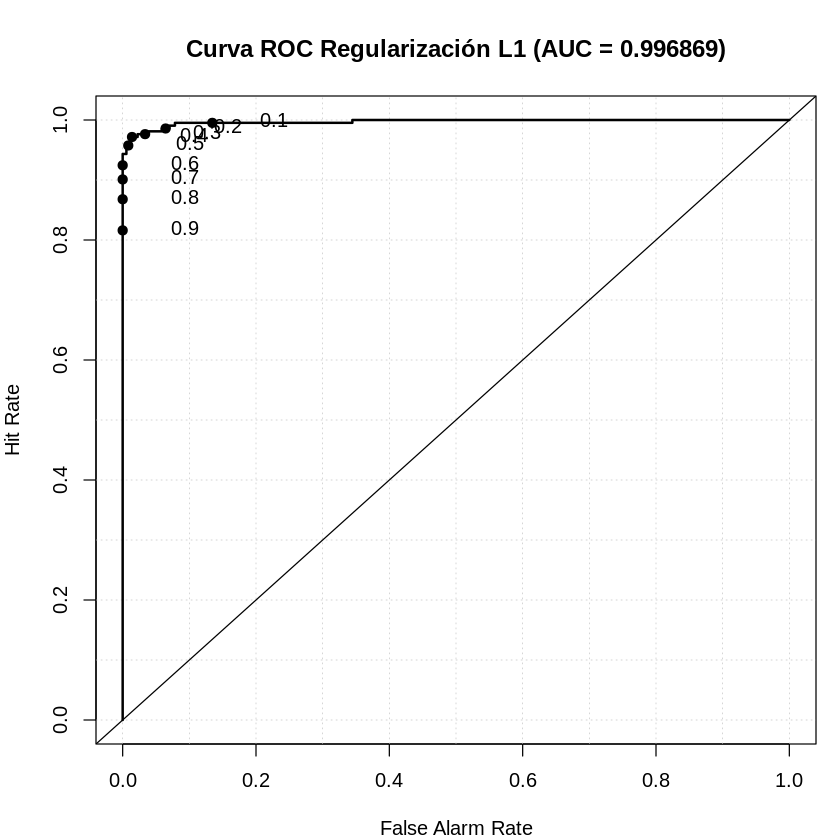

In [71]:
pred.l1 <- predict(model.l1,as.matrix(df[-1]),type = "response")
auc.l1 <- roc.area(df$diagnosis,pred.l1)$A
roc.plot(df$diagnosis,pred.l1, main=sprintf("Curva ROC Regularización L1 (AUC = %g)", auc.l1))

Observamos como, aún con solo 10 variables, el AUC es todavía bastante alto. Por ello se propone la siguiente tarea.

**TAREA 4:** Utilizar una validación cruzada tipo _hold out_ para comprobar si la capacidad de generalización del modelo ha mejorado con la regularización L1.

In [112]:
traincv <- cv.glmnet(as.matrix(trainData[-1]),trainData$diagnosis,family = "binomial",alpha = 1)
traincv$lambda.1se

[1] 0.00867884

In [113]:
trainmodel.l1 <- glmnet(as.matrix(trainData[-1]), trainData$diagnosis, family = "binomial", alpha = 1, lambda = traincv$lambda.1se)
ind.coef.no.nulos <- which(as.numeric(coef(trainmodel.l1)) != 0)
names(trainData)[ind.coef.no.nulos]
cat(paste("Number of variables selected:", length(ind.coef.no.nulos)))

[1] "diagnosis"              "texture_mean"           "concave.points_mean"   
 [4] "fractal_dimension_mean" "radius_se"              "fractal_dimension_se"  
 [7] "radius_worst"           "texture_worst"          "smoothness_worst"      
[10] "concavity_worst"        "concave.points_worst"   "symmetry_worst"

Number of variables selected: 12

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 149  75
         1  59  59
                                          
               Accuracy : 0.6082          
                 95% CI : (0.5542, 0.6602)
    No Information Rate : 0.6082          
    P-Value [Acc > NIR] : 0.5237          
                                          
                  Kappa : 0.16            
                                          
 Mcnemar's Test P-Value : 0.1950          
                                          
            Sensitivity : 0.7163          
            Specificity : 0.4403          
         Pos Pred Value : 0.6652          
         Neg Pred Value : 0.5000          
             Prevalence : 0.6082          
         Detection Rate : 0.4357          
   Detection Prevalence : 0.6550          
      Balanced Accuracy : 0.5783          
                                          
       'Positive' Class : 0               
                              

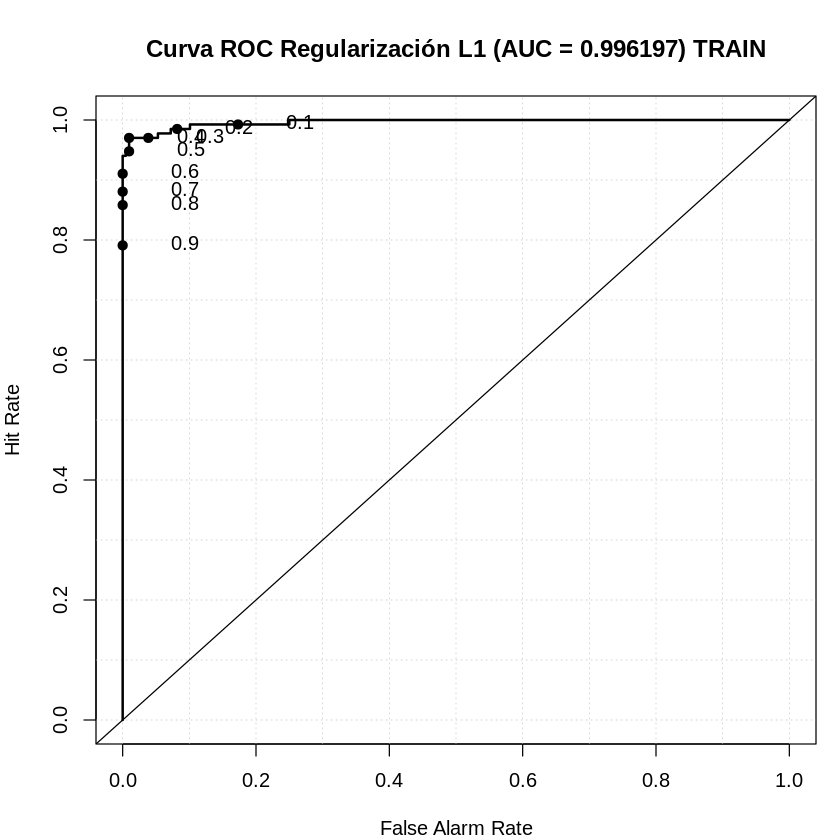

In [116]:
trainpred.l1 <- predict(trainmodel.l1,as.matrix(trainData[-1]),type = "response")
trainauc.l1 <- roc.area(trainData$diagnosis,trainpred.l1)$A
confusionMatrix(as.factor(round(trainpred.l2)),as.factor(trainData$diagnosis))
roc.plot(trainData$diagnosis,trainpred.l1, main=sprintf("Curva ROC Regularización L1 (AUC = %g) TRAIN", trainauc.l1))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 101  45
         1  48  33
                                          
               Accuracy : 0.5903          
                 95% CI : (0.5233, 0.6549)
    No Information Rate : 0.6564          
    P-Value [Acc > NIR] : 0.9840          
                                          
                  Kappa : 0.1             
                                          
 Mcnemar's Test P-Value : 0.8357          
                                          
            Sensitivity : 0.6779          
            Specificity : 0.4231          
         Pos Pred Value : 0.6918          
         Neg Pred Value : 0.4074          
             Prevalence : 0.6564          
         Detection Rate : 0.4449          
   Detection Prevalence : 0.6432          
      Balanced Accuracy : 0.5505          
                                          
       'Positive' Class : 0               
                              

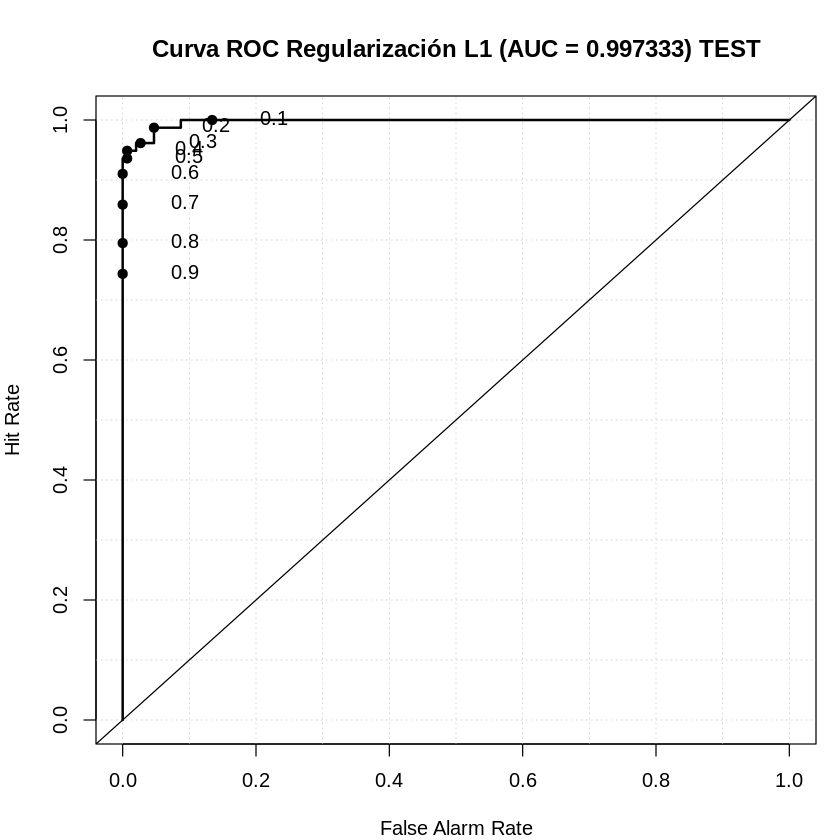

In [117]:
testpred.l1 <- predict(trainmodel.l1,as.matrix(testData[-1]),type = "response")
testauc.l1 <- roc.area(testData$diagnosis,testpred.l1)$A
confusionMatrix(as.factor(round(testpred.l2)),as.factor(testData$diagnosis))
roc.plot(testData$diagnosis,testpred.l1, main=sprintf("Curva ROC Regularización L1 (AUC = %g) TEST", testauc.l1))

Utilizando la regularización L1, vemos cómo se seleccionaron 13 variables, y aunque el AUC es alto para los mismos datos de entrenamiento usados (60% de los datos), también lo es para los datos de test.

El accuracy para los datos de train ronda el 60%, mientras que para los datos de test ronda el 59%, demostrando que existió una penalización del modelo y hay una generalización.

Si probásemos con la regularización L2 (parámetro alpha = 0), la norma de los módulos se limita pero en este caso ningún coeficiente es 0.

In [118]:
cv2 <- cv.glmnet(as.matrix(df[-1]),df$diagnosis,family = "binomial",alpha = 0)
cv2$lambda.1se
model.l2 <- glmnet(as.matrix(df[-1]), df$diagnosis, family = "binomial", alpha = 0, lambda = cv2$lambda.1se)
ind.coef.no.nulos.l2 <- which(as.numeric(coef(model.l2)) != 0)
cat(paste("Number of variables selected:", length(ind.coef.no.nulos.l2)))

[1] 0.05072067

Number of variables selected: 30

Calculamos el AUC para el modelo regularizado con el penalty L2.

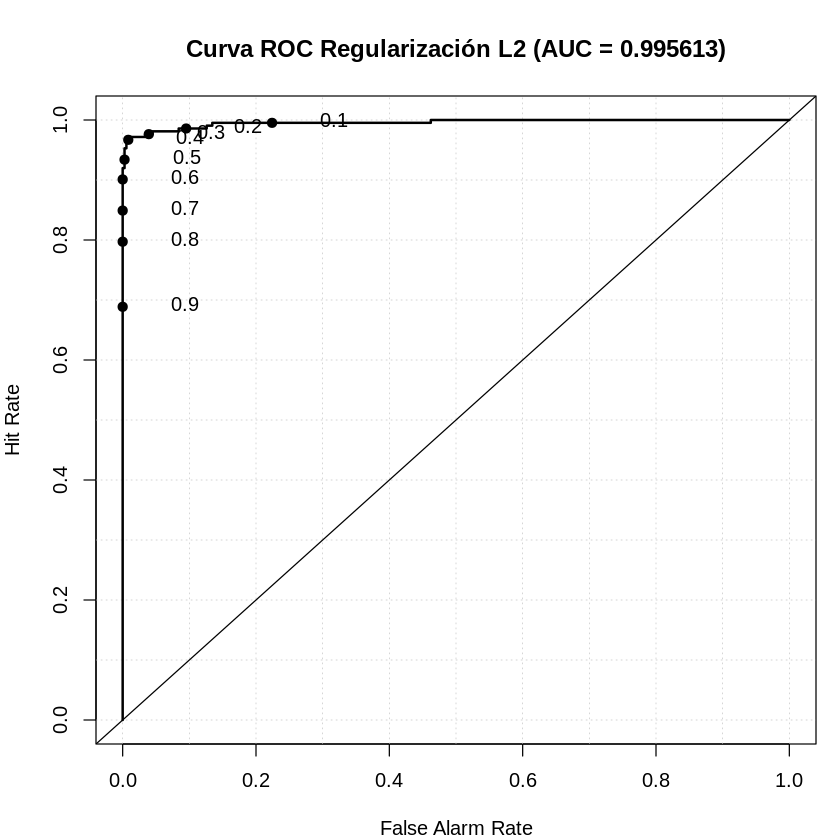

In [119]:
pred.l2 <- predict(model.l2,as.matrix(df[-1]),type = "response")
auc.l2 <- roc.area(df$diagnosis,pred.l2)$A
roc.plot(df$diagnosis,pred.l2, main=sprintf("Curva ROC Regularización L2 (AUC = %g)", auc.l2))

**TAREA 5:** Comprobar la capacidad de generalización del modelo regularizado mediante _ridge regression_ y estudiar la evolución de los valores de los coeficientes en función del valor de `lambda`

In [120]:
traincv2 <- cv.glmnet(as.matrix(trainData[-1]),trainData$diagnosis,family = "binomial",alpha = 0)
traincv2$lambda.1se
trainmodel.l2 <- glmnet(as.matrix(trainData[-1]), trainData$diagnosis, family = "binomial", alpha = 0, lambda = traincv2$lambda.1se)
ind.coef.no.nulos.l2 <- which(as.numeric(coef(trainmodel.l2)) != 0)
cat(paste("Number of variables selected:", length(ind.coef.no.nulos.l2)))

[1] 0.08284374

Number of variables selected: 30

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 208   8
         1   0 126
                                          
               Accuracy : 0.9766          
                 95% CI : (0.9544, 0.9898)
    No Information Rate : 0.6082          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9504          
                                          
 Mcnemar's Test P-Value : 0.01333         
                                          
            Sensitivity : 1.0000          
            Specificity : 0.9403          
         Pos Pred Value : 0.9630          
         Neg Pred Value : 1.0000          
             Prevalence : 0.6082          
         Detection Rate : 0.6082          
   Detection Prevalence : 0.6316          
      Balanced Accuracy : 0.9701          
                                          
       'Positive' Class : 0               
                              

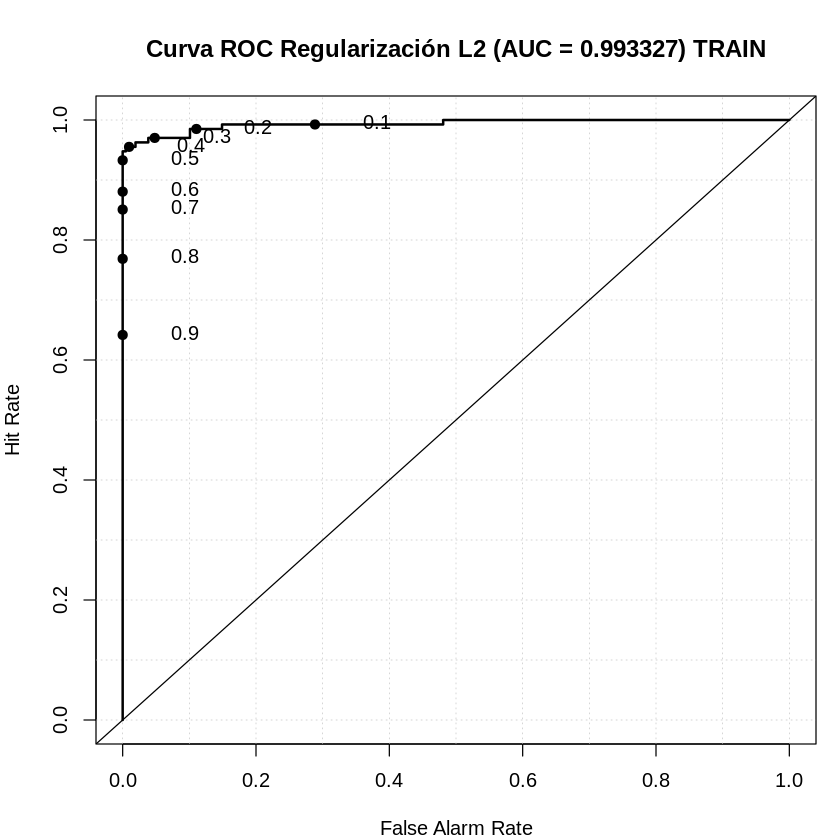

In [121]:
trainpred.l2 <- predict(trainmodel.l2,as.matrix(trainData[-1]),type = "response")
trainauc.l2 <- roc.area(trainData$diagnosis,trainpred.l2)$A
confusionMatrix(as.factor(round(trainpred.l2)),as.factor(trainData$diagnosis))
roc.plot(trainData$diagnosis,trainpred.l2,main=sprintf("Curva ROC Regularización L2 (AUC = %g) TRAIN", trainauc.l2))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 148   8
         1   1  70
                                          
               Accuracy : 0.9604          
                 95% CI : (0.9261, 0.9817)
    No Information Rate : 0.6564          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9102          
                                          
 Mcnemar's Test P-Value : 0.0455          
                                          
            Sensitivity : 0.9933          
            Specificity : 0.8974          
         Pos Pred Value : 0.9487          
         Neg Pred Value : 0.9859          
             Prevalence : 0.6564          
         Detection Rate : 0.6520          
   Detection Prevalence : 0.6872          
      Balanced Accuracy : 0.9454          
                                          
       'Positive' Class : 0               
                              

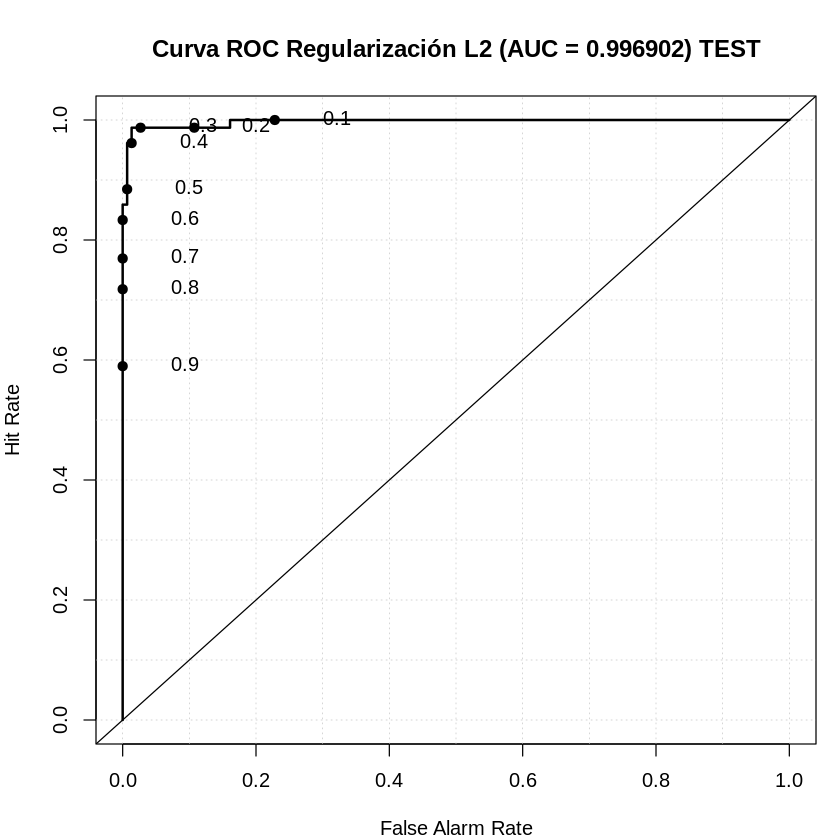

In [122]:
testpred.l2 <- predict(trainmodel.l2,as.matrix(testData[-1]),type = "response")
testauc.l2 <- roc.area(testData$diagnosis,testpred.l2)$A
confusionMatrix(as.factor(round(testpred.l2)),as.factor(testData$diagnosis))
roc.plot(testData$diagnosis,testpred.l2,main=sprintf("Curva ROC Regularización L2 (AUC = %g) TEST", testauc.l2))

**TAREA 6:** Aplicar lo aprendido en esta práctica a otra de las bases de datos de ejemplo.